# Bayesian black-box model-predictive control

An Expected Free Energy minimizing agent based on a nonlinear autoregressive model with exogenous input applied to a driven damped pendulum.

## System: driven damped pendulum

Consider a single pendulum with angle $\theta(t)$ and input $u(t)$ evolving according to:

$$ \ddot{\theta} + \frac{\mathcal{g}}{l} \sin(\theta) + \frac{\gamma}{l} \dot{\theta} = \frac{1}{ml} u\, .$$

where $m$ is mass, $l$ is length, $\gamma$ is damping and $\mathcal{g}$ is Earth's gravity.

In [1]:
using Revise
using Optim
using RxInfer
using LinearAlgebra
using ProgressMeter
using Distributions
using Plots; default(grid=false, label="", linewidth=3,margin=10Plots.pt)
include("../util.jl");
include("Pendulum.jl");

In [2]:
# System parameters
sys_mass = 2.0
sys_length = 0.5
sys_damping = 0.1
sys_mnoise_sd = 1e-2

0.01

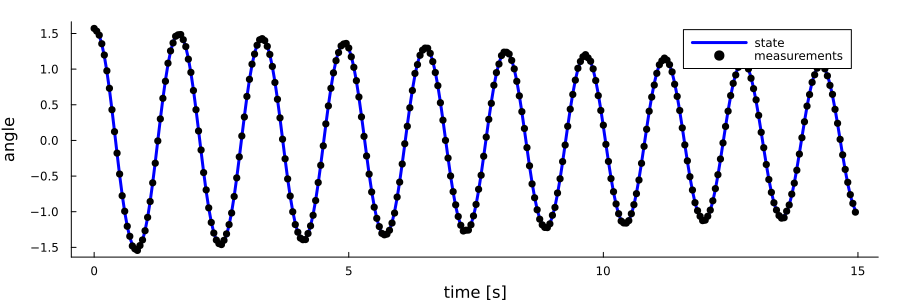

In [3]:
T = 300
Δt = 0.05
time = range(0.0, step=Δt, length=T)

init_state = [π/2, 0.0]
pendulum = Pendulum(init_state, sys_mass, sys_length, sys_damping, sys_mnoise_sd)

states = zeros(2,T)
observations = zeros(T)

controls = zeros(T)

for k in 1:T
    states[:,k] = pendulum.state
    observations[k] = pendulum.sensor
    step!(pendulum, controls[k], Δt=Δt)
end

plot(xlabel="time [s]",ylabel="angle", size=(900,300))
plot!(time, states[1,:], color="blue", label="state")
scatter!(time, observations, color="black", label="measurements")

## NARX parameter estimation

In [4]:
# Length of trial
T      = 500
time   = range(0.0, step=Δt, length=T);
thorizon = 5;

In [5]:
# Degree
H = 1

# Basis expansion
# ϕ(x; N::Int64 = 10) = [1; cat([[cos.(2π*n*x); sin.(2π*n*x)] for n = 1:N]..., dims=1)]
ϕ(x; D::Integer = 1) = cat([1; [x.^d for d in 1:D]]...,dims=1)
# ϕ(x; N::Integer = 1) = [1; x; x.^2]
# ϕ(x; N::Integer = 1) = [1; x]

ϕ (generic function with 1 method)

In [6]:
# Delay order
Lx = 3
Lu = 3

# Model order
M = size(ϕ(zeros(Lx+Lu), D=H),1)

7

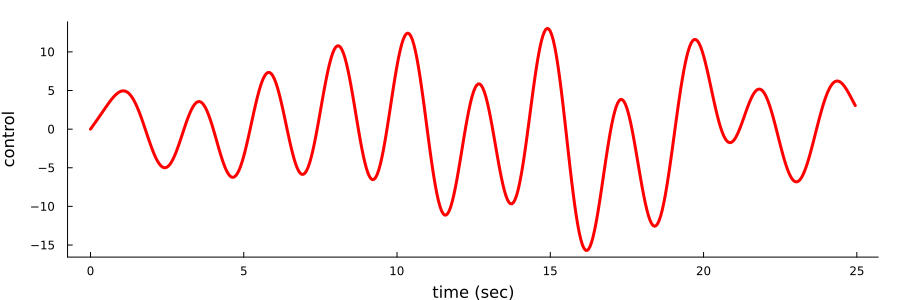

In [7]:
# Control policy
# Ω = 10 .^range(-6,stop=2, length=30)
# u_ = 100*mean([sin.(ω.*time) for ω in Ω]);

# function u(t)
#     u = 1.0
#     if t > 1.0
#         u = 0.0
#     end
#     return
# end
# u_ = u(range(0.0, step=nt*dt, length=T+thorizon))

# Pulse
# u_ = [zeros(10); ones(100); zeros(T-110)];
A  = rand(10)*200 .- 100
Ω  = rand(10)*3
u_ = mean([A[i]*sin.(Ω[i].*time) for i = 1:10])

plot(time, u_, size=(900,300), color="red", xlabel="time (sec)", ylabel="control")

In [8]:
@model function NARX(pθ_k, pτ_k)
    
    ϕ = datavar(Vector{Float64})
    y = datavar(Float64)
    
    # Priors
    θ  ~ MvNormalMeanCovariance(mean(pθ_k), cov(pθ_k))
    τ  ~ GammaShapeRate(shape(pτ_k), rate(pτ_k))
        
    # Likelihood
    y ~ NormalMeanPrecision(dot(θ,ϕ), τ)
end

In [9]:
function future(controls, xbuffer, ubuffer, params; time_horizon=1)
    
    m_y = zeros(time_horizon)
    v_y = zeros(time_horizon)

    # Unpack parameters
    mθ,Sθ,mτ = params

    # Recursive buffer
    vbuffer = 1e-8*ones(length(mθ))
    
    for t in 1:time_horizon
        
        # Update control buffer
        ubuffer = backshift(ubuffer, controls[t])
        
        # Prediction
        ϕ_k = ϕ([xbuffer; ubuffer], D=H)
        m_y[t] = dot(mθ, ϕ_k)
        v_y[t] = ϕ_k'*Sθ*ϕ_k + inv(mτ)
        
        # Update previous 
        xbuffer = backshift(xbuffer, m_y[t])
        vbuffer = backshift(vbuffer, v_y[t])     
        
    end
    return m_y, v_y
end

future (generic function with 1 method)

In [55]:
# Specify prior distributions
pτ0 = GammaShapeRate(1e0, 1e0)
pθ0 = MvNormalMeanCovariance(ones(M), 1e2diagm(ones(M)))

MvNormalMeanCovariance(
μ: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Σ: [100.0 0.0 … 0.0 0.0; 0.0 100.0 … 0.0 0.0; … ; 0.0 0.0 … 100.0 0.0; 0.0 0.0 … 0.0 100.0]
)


In [56]:
# Initialize beliefs
pτ = [pτ0]
pθ = [pθ0]

1-element Vector{MvNormalMeanCovariance{Float64, Vector{Float64}, Matrix{Float64}}}:
 MvNormalMeanCovariance(
μ: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Σ: [100.0 0.0 … 0.0 0.0; 0.0 100.0 … 0.0 0.0; … ; 0.0 0.0 … 100.0 0.0; 0.0 0.0 … 0.0 100.0]
)


In [12]:
# Clear memory
pτ = [pτ[end]]
pθ = [pθ[end]]

1-element Vector{MvNormalMeanPrecision{Float64, Vector{Float64}, Matrix{Float64}}}:
 MvNormalMeanPrecision(
μ: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Λ: [0.0001 0.0 … 0.0 0.0; 0.0 0.0001 … 0.0 0.0; … ; 0.0 0.0 … 0.0001 0.0; 0.0 0.0 … 0.0 0.0001]
)


In [13]:
# VI options
num_iters = 5;
constraints = @constraints begin 
    q(θ, τ) = q(θ)q(τ)
end

Constraints:
  marginals form:
  messages form:
  factorisation:
    q(θ, τ) = q(θ)q(τ)
Options:
  warn = true


In [14]:
# Preallocate
z_ = zeros(2,T)
y_ = zeros(T)
u_ = zeros(T)
pred_m = zeros(thorizon,T)
pred_s = zeros(thorizon,T)

for j in 1:3

    A  = randn(10)*5
    Ω  = rand(10)*3
    u_ = mean([A[i]*sin.(Ω[i].*time) for i = 1:10])

    # Initial state
    init_state = [randn(), 0.0]

    # Start system
    pendulum = Pendulum(init_state, sys_mass, sys_length, sys_damping, sys_mnoise_sd)

    # Preallocate
    z_ = zeros(2,T)
    y_ = zeros(T)
    ϕ_ = zeros(M,T)
    xbuffer = zeros(Lx)
    ubuffer = zeros(Lu)
    pred_m = zeros(thorizon,T)
    pred_s = zeros(thorizon,T)

    @showprogress for (k,t) in enumerate(time[1:T-thorizon])

        "Act upon environment"

        # Alter system state based on control
        step!(pendulum, u_[k], Δt=Δt)

        "Update parameter beliefs"

        ubuffer = backshift(ubuffer, u_[k])
        ϕ_[:,k] = ϕ([xbuffer; ubuffer], D=H)

        # VI iterations
        results = inference(
            model         = NARX(pθ[end], pτ[end]), 
            data          = (y = pendulum.sensor, ϕ = ϕ_[:,k]), 
            initmarginals = (θ = pθ0, τ = pτ0),
            initmessages  = (θ = pθ0, τ = pτ0),
            returnvars    = (θ = KeepLast(), τ = KeepLast(),),
            constraints   = constraints, 
            iterations    = num_iters,
        )

        # Update beliefs
        push!(pθ, results.posteriors[:θ])
        push!(pτ, results.posteriors[:τ])

        xbuffer = backshift(xbuffer, pendulum.sensor)

        # Store future predictions
        pred_m[:,k], pred_s[:,k] = future(u_[k:k+thorizon], 
                                          xbuffer, 
                                          ubuffer, 
                                          (mode(pθ[end]), cov(pθ[end]), mode(pτ[end])), 
                                          time_horizon=thorizon)

        # Track states and sensor measurements
        z_[:,k] = pendulum.state
        y_[k]   = pendulum.sensor

    end
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:15
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


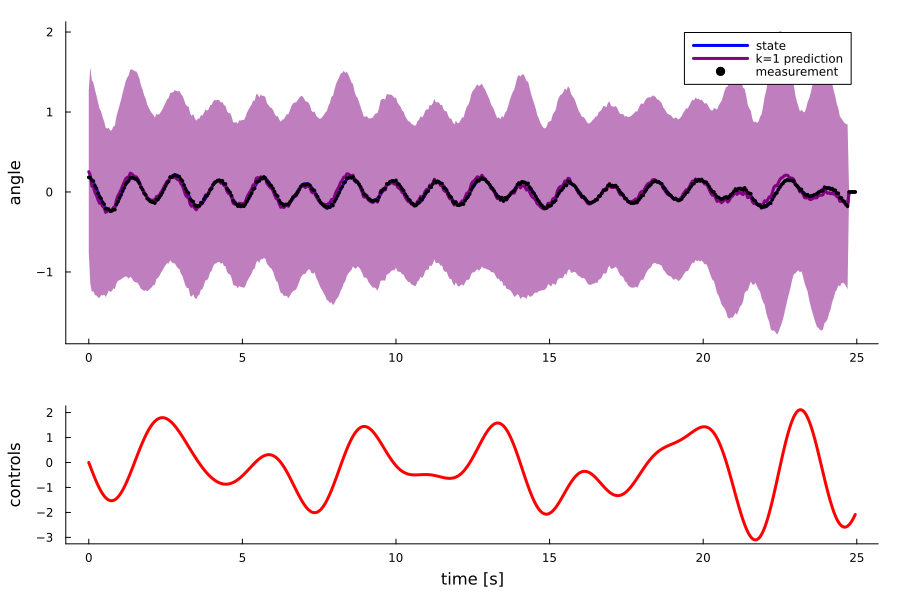

In [15]:
K = 1
p1 = plot(time, z_[1,:], color="blue", label="state", ylabel="angle")
plot!(time, pred_m[K,:], ribbon=pred_s[K,:], color="purple", label="k=$K prediction")
scatter!( time, y_, color="black", markersize=2, label="measurement")
p4 = plot(time, u_, color="red", ylabel="controls", xlabel="time [s]")

plot(p1,p4, layout=grid(2,1, heights=[.7, .3]), size=(900,600))

In [16]:
savefig("figures/NARX-EFE-pendulum_filtering.png")

"/home/wmkouw/syndr/Wouter/Onderzoek/Projecten/tue/efe-acquisition/narx-efe/pendulum/figures/NARX-EFE-pendulum_filtering.png"

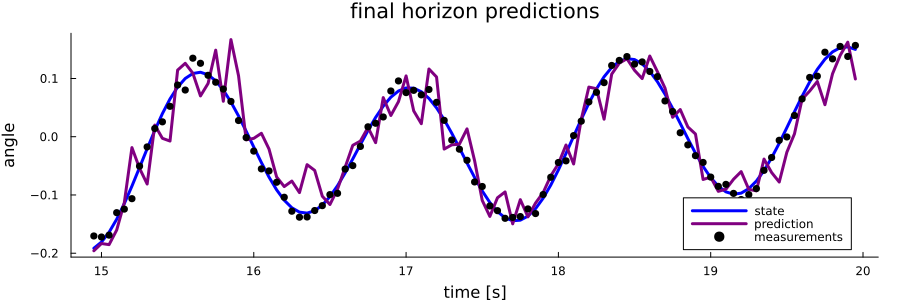

In [17]:
ix = 300:400
p2 = plot(size=(900,300), xlabel="time [s]", ylabel="angle")
plot!(time[ix], z_[1,ix], color="blue", label="state")
# plot!(time[ix], pred_m[end,ix .- thorizon], ribbon=pred_s[end,ix .- thorizon], color="purple", label="prediction")
plot!(time[ix], pred_m[end,ix .- thorizon], color="purple", label="prediction")
scatter!(time[ix], y_[ix], color="black", label="measurements", title="final horizon predictions")

[ Info: Saved animation to /home/wmkouw/syndr/Wouter/Onderzoek/Projecten/tue/efe-acquisition/narx-efe/pendulum/figures/NARX-EFE-pendulum_prediction.gif


Plots.AnimatedGif("/home/wmkouw/syndr/Wouter/Onderzoek/Projecten/tue/efe-acquisition/narx-efe/pendulum/figures/NARX-EFE-pendulum_prediction.gif")
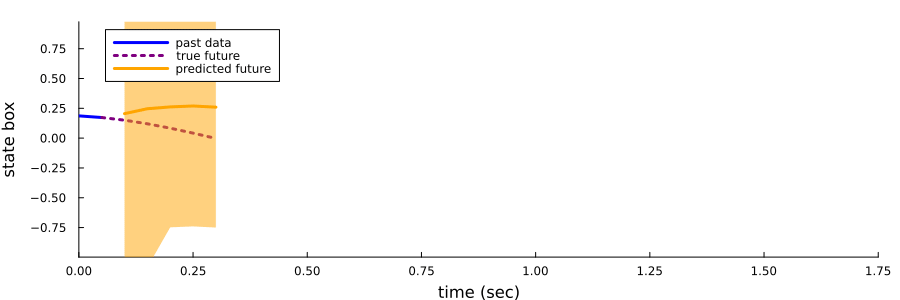

In [18]:
limsb = [minimum(z_[2,:])*1.1, maximum(z_[2,:])*1.1]

window = 20

anim = @animate for k in 2:2:(T-thorizon-1)
    
    if k <= window
        plot(time[1:k], z_[1,1:k], color="blue", xlims=(time[1], time[window+thorizon+1]+0.5), label="past data", ylabel="state box", xlabel="time (sec)", ylims=limsb, size=(900,300))
        plot!(time[k:k+thorizon], z_[1,k:k+thorizon], color="purple", label="true future", linestyle=:dot)
        plot!(time[k+1:k+thorizon], pred_m[:,k], ribbon=pred_s[:,k], label="predicted future", color="orange", legend=:topleft)
    else
        plot(time[k-window:k], z_[1,k-window:k], color="blue", xlims=(time[k-window], time[k+thorizon+1]+0.5), label="past data", ylabel="state box", xlabel="time (sec)", ylims=limsb, size=(900,300))
        plot!(time[k:k+thorizon], z_[1,k:k+thorizon], color="purple", label="true future", linestyle=:dot)
        plot!(time[k+1:k+thorizon], pred_m[:,k], ribbon=pred_s[:,k], label="prediction", color="orange", legend=:topleft)
    end
end
gif(anim, "figures/NARX-EFE-pendulum_prediction.gif", fps=24)

## Expected Free Energy minimization

In [104]:
function EFE(control, xbuffer, ubuffer, goalp, params; λ=0.01, time_horizon=1)
    "Expected Free Energy"
    
    # Unpack goal state
    m_star, v_star = goalp

    # Unpack parameters
    mθ, Sθ, mτ = params

    # Recursive buffer
    vbuffer = 1e-8*ones(length(mθ))
    
    cEFE = 0
    for t in 1:time_horizon
        
        # Update control buffer
        ubuffer = backshift(ubuffer, control[t])
        
        # Prediction
        ϕ_k = ϕ([xbuffer; ubuffer], D=H)
        m_y = dot(mθ, ϕ_k)
        v_y = ϕ_k'*Sθ*ϕ_k + inv(mτ)

        # Conditional entropy of q(y|u)
        ambiguity = log(v_y)./2
        
        # KL-divergence between predicted marginal and goal prior
        risk = 0.5*(log(v_star/v_y) + (m_y - m_star)'*inv(v_star)*(m_y - m_star) + tr(inv(v_star)*v_y))
        
        # Add to cumulative EFE
#         cEFE += risk + ambiguity + λ*control[t]^2
        cEFE += risk + λ*control[t]^2
        
        # Update previous 
        xbuffer = backshift(xbuffer, m_y)
        vbuffer = backshift(vbuffer, v_y)        
    end
    return cEFE
end;

In [105]:
# Length of trial
T      = 1000
time   = range(0.0, step=Δt, length=T)
thorizon = 10;

# VI options
num_iters = 5;
constraints = @constraints begin 
    q(θ, τ) = q(θ)q(τ)
end

# Set control properties
setpoint = 3.141592
goal_prior = (setpoint, 1e-3)
u_lims = (-100, 100)
opts = Optim.Options(time_limit=10)

# Initial state
init_state = [0.0, 0.0]

# Initialize beliefs
pτ = [pτ0]
pθ = [pθ0]

# Start system
pendulum = Pendulum(init_state, sys_mass, sys_length, sys_damping, sys_mnoise_sd)

# Preallocate
z_ = zeros(2,T)
y_ = zeros(T)
u_ = zeros(T+1)
ϕ_k = zeros(M)
xbuffer = zeros(Lx)
ubuffer = zeros(Lu)
pred_m = zeros(thorizon,T)
pred_s = zeros(thorizon,T)
fe = zeros(num_iters, T)

@showprogress for (k,t) in enumerate(time)
    
    "Act upon environment"
    
    step!(pendulum, u_[k], Δt=Δt)
    
    "Update parameter beliefs"
    
    # Inputs
    ubuffer = backshift(ubuffer, u_[k])
    ϕ_k = ϕ([xbuffer; ubuffer], D=H)
    
    # VI iterations
    results = inference(
        model         = NARX(pθ[end], pτ[end]), 
        data          = (y = pendulum.sensor, ϕ = ϕ_k),
        constraints   = constraints, 
        iterations    = num_iters, 
        initmarginals = (θ = pθ0, τ = pτ0),
        initmessages  = (θ = pθ0, τ = pτ0),
        returnvars    = (θ = KeepLast(), τ = KeepLast(),),        
        free_energy   = true,
    )
    fe[:,k] = results.free_energy
    
    # Update beliefs
    push!(pθ, results.posteriors[:θ])
    push!(pτ, results.posteriors[:τ])
    
    "Optimal control"
    
    # Extract MAP parameters
    mθ = mode(results.posteriors[:θ])
    Sθ = cov( results.posteriors[:θ])
    mτ = mode(results.posteriors[:τ])
    
    # Objective function
    J(policy) = EFE(policy, xbuffer, ubuffer, goal_prior, (mθ, Sθ, mτ), λ=1e-2, time_horizon=thorizon)

    # Minimize
    results = optimize(J, zeros(thorizon), LBFGS(), opts, autodiff=:forward)
    
    # Control law
    policy = Optim.minimizer(results)
    u_[k+1] = policy[1]
    
    "Bookkeeping"
    
    # Store future predictions
    pred_m[:,k], pred_s[:,k] = future(policy, 
                                      xbuffer, 
                                      ubuffer, 
                                      (mθ, Sθ, mτ), 
                                      time_horizon=thorizon)
    
    # Update previous observations buffer
    xbuffer = backshift(xbuffer, pendulum.sensor)

    # Track states and sensors
    z_[:,k] = pendulum.state
    y_[k]   = pendulum.sensor
    
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:12


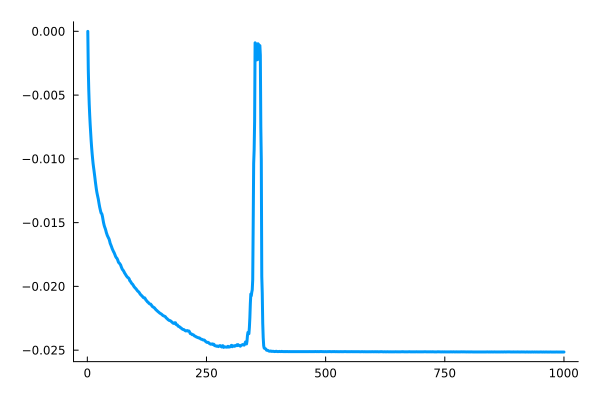

In [106]:
plot(fe[end,:] .- fe[1,:])

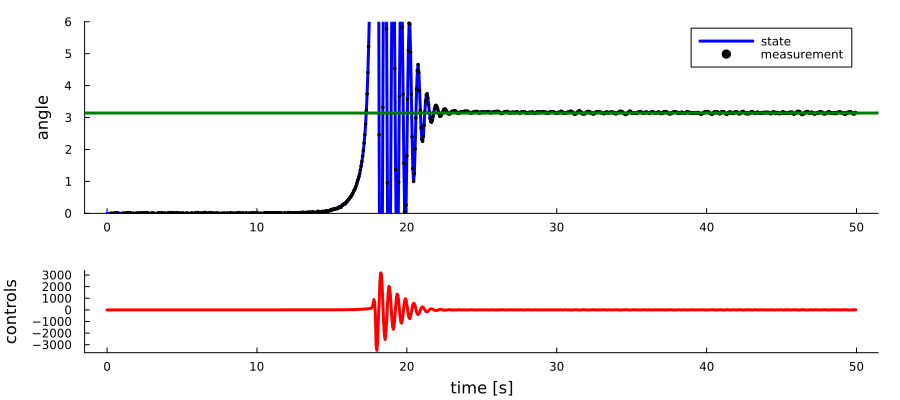

In [107]:
p1 = plot(time, z_[1,:], color="blue", label="state", ylabel="angle")
scatter!( time, y_, color="black", markersize=2, label="measurement")
hline!([setpoint], color="green", ylims=[0., 6.])
p4 = plot(time, u_[1:end-1], color="red", ylabel="controls", xlabel="time [s]")

plot(p1,p4, layout=grid(2,1, heights=[.7, .3]), size=(900,400))

In [108]:
savefig("figures/NARX-EFE-pendulum_trial00.png")

"/home/wmkouw/syndr/Wouter/Onderzoek/Projecten/tue/efe-acquisition/narx-efe/pendulum/figures/NARX-EFE-pendulum_trial00.png"

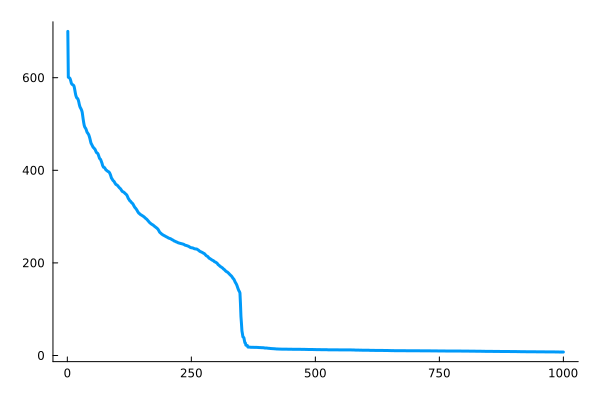

In [109]:
tSθ = [tr(cov(pθ[k])) for k in 1:T]
plot(tSθ)

[ Info: Saved animation to /home/wmkouw/syndr/Wouter/Onderzoek/Projecten/tue/efe-acquisition/narx-efe/pendulum/figures/NARX-EFE-pendulum_plan_trial00.gif


Plots.AnimatedGif("/home/wmkouw/syndr/Wouter/Onderzoek/Projecten/tue/efe-acquisition/narx-efe/pendulum/figures/NARX-EFE-pendulum_plan_trial00.gif")
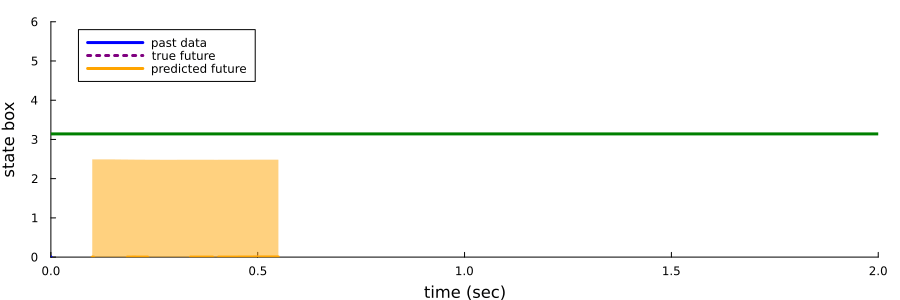

In [84]:
limsb = [minimum(z_[2,:])*1.5, maximum(z_[2,:])*1.5]

window = 20

anim = @animate for k in 2:2:(T-thorizon-1)
    
    if k <= window
        plot(time[1:k], z_[1,1:k], color="blue", xlims=(time[1], time[window+thorizon+1]+0.5), label="past data", ylabel="state box", xlabel="time (sec)", ylims=limsb, size=(900,300))
        plot!(time[k:k+thorizon], z_[1,k:k+thorizon], color="purple", label="true future", linestyle=:dot)
        plot!(time[k+1:k+thorizon], pred_m[:,k], ribbon=pred_s[:,k], label="predicted future", color="orange", legend=:topleft)
        hline!([setpoint], color="green", ylims=[0., 6.])
    else
        plot(time[k-window:k], z_[1,k-window:k], color="blue", xlims=(time[k-window], time[k+thorizon+1]+0.5), label="past data", ylabel="state box", xlabel="time (sec)", ylims=limsb, size=(900,300))
        plot!(time[k:k+thorizon], z_[1,k:k+thorizon], color="purple", label="true future", linestyle=:dot)
        plot!(time[k+1:k+thorizon], pred_m[:,k], ribbon=pred_s[:,k], label="prediction", color="orange", legend=:topleft)
        hline!([setpoint], color="green", ylims=[0., 6.])
    end
end
gif(anim, "figures/NARX-EFE-pendulum_plan_trial00.gif", fps=24)

In [85]:
mean(pθ[end])

7-element Vector{Float64}:
 0.008073418749014427
 0.27883935415976696
 0.5068727101590451
 0.6855272794867545
 1.097083173064336
 0.691181830471399
 0.47172565235119956